In [1]:
import numpy as np 
import pandas as pd
import pickle
import re
import string
from cltk.stop.latin.stops import STOPS_LIST
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import LatentDirichletAllocation, NMF, TruncatedSVD
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from gensim import corpora, models, similarities, matutils
from gensim.models import LdaModel
from pymongo import MongoClient
from copy import deepcopy
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
texts = pickle.load(open('pickles/texts.pkl','rb'))
texts_train = pickle.load(open('pickles/texts_train.pkl','rb'))
texts_test = pickle.load(open('pickles/texts_test.pkl','rb'))
data_train = pickle.load(open('pickles/root_train.pkl','rb'))
data_test = pickle.load(open('pickles/root_test.pkl','rb'))
train_indices = pickle.load(open('pickles/train_indices.pkl','rb'))

In [3]:
def get_lda_topics(model, model_pkg, n_words, feature_names=None, topic_names=None):
    ''' feature names needed if model_pkg='sklearn'
    '''
    if model_pkg == 'sklearn':
        for ix, topic in enumerate(model.components_):
            if not topic_names or not topic_names[ix]:
                print('\nTopic', ix)
            else:
                print('\nTopic', ix, topic_names[ix])
            print(' '.join([feature_names[i]
                            for i in topic.argsort()[:-n_words - 1:-1]]))
    elif model_pkg == 'gensim':
        model_result = model.show_topics(num_words=n_words, log=False, formatted=False)
        for ix, topic in enumerate(model_result):
            word_list = [word[0] for word in topic[1]]
            if not topic_names or not topic_names[ix]:
                print ('\nTopic', ix)
            else:
                print('\n Topic', ix, topic_names[ix])
            print(' '.join(word_list))            
        
    else:
        return 'error: model_pkg must be "sklearn" or "gensim"'

    return

In [4]:
class topic_modeler:
    
    def __init__ (self, features):
        self.features = features
   
   # use vectorizer and run reducer
    def run_reducer(self,reducer):
        self.reducer = reducer
        model = self.reducer
        self.vec_data = model.fit_transform(self.features)
   
   # use results from reducer in clustering model and get clusters
    def run_clusterer(self,clusterer):
        self.clusterer = clusterer
        model = self.clusterer
        self.clusters = model.fit_predict(self.vec_data)

In [5]:
def plot_score_clusters(features,k_list):

    SSEs = []
    #sil_coefs = []
    for k in k_list:
        km = KMeans(n_clusters=k, random_state=42, max_iter=100, n_jobs=-1)
        km.fit(features)
        labels = km.labels_
        #sil_coefs.append(silhouette_score(features, labels, metric='euclidean'))
        SSEs.append(km.inertia_) 

    #fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,5), sharex=True, dpi=200)
    #ax1.plot(k_list, sil_coefs)
    #ax1.set_xlabel('number of clusters')
    #ax1.set_ylabel('silhouette coefficient')

    # plot here on ax2
    plt.plot(k_list, SSEs)
    plt.xlabel('number of clusters')
    plt.ylabel('SSE')
    plt.show;
    
    return

In [51]:
client = MongoClient()
db = client.latinlit
db.collection_names()

['rootdata', 'splitdata', 'data', 'roottrain', 'roottest']

In [53]:
latin_stopwords = STOPS_LIST
latin_stopwords += list(string.ascii_lowercase)

In [55]:
cv = CountVectorizer(ngram_range=(1,2), stop_words=latin_stopwords, max_df=0.8, min_df=0.005)
# well, this was supposed to be just on the train set so the naming seems misleading 
cv_train = cv.fit_transform(texts)
# cv_test = cv.transform(texts_test)

df_cv = pd.DataFrame(cv_train.toarray(), columns=cv.get_feature_names())

In [56]:
cvlim = CountVectorizer(ngram_range=(1,2), stop_words=latin_stopwords, max_df=0.6, min_df=0.01)
cvlim_train = cvlim.fit_transform(texts)
#cvlim_test = cvlim.transform(texts_test)

df_cvlim = pd.DataFrame(cvlim_train.toarray(), columns=cvlim.get_feature_names())

In [57]:
tv = TfidfVectorizer(ngram_range=(1,2), stop_words=latin_stopwords, max_df=0.8, min_df=0.005)
tv_train = tv.fit_transform(texts)
#tv_test = tv.transform(texts_test)

df_tv = pd.DataFrame(tv_train.toarray(), columns=tv.get_feature_names())

In [58]:
tvlim = TfidfVectorizer(ngram_range=(1,2), stop_words=latin_stopwords, max_df=0.6, min_df=0.01)
tvlim_train = tvlim.fit_transform(texts)
#tvlim_test = tvlim.transform(texts_test)

df_tvlim = pd.DataFrame(tvlim_train.toarray(), columns=tvlim.get_feature_names())

In [147]:
df_cv.shape

(117194, 1659)

In [148]:
df_cvlim.shape

(117194, 814)

In [149]:
df_tv.shape

(117194, 1659)

In [150]:
df_tvlim.shape

(117194, 814)

In [98]:
# Convert sparse matrix of counts to a gensim corpus
tv_counts = tv_train.transpose()
tv_corpus = matutils.Sparse2Corpus(tv_counts)
tv_vocab = dict((v, k) for k, v in tv.vocabulary_.items())
tvlim_counts = tvlim_train.transpose()
tvlim_corpus = matutils.Sparse2Corpus(tvlim_counts)
tvlim_vocab = dict((v, k) for k, v in tvlim.vocabulary_.items())
cv_counts = cv_train.transpose()
cv_corpus = matutils.Sparse2Corpus(cv_counts)
cv_vocab = dict((v, k) for k, v in cv.vocabulary_.items())
cvlim_counts = cvlim_train.transpose()
cvlim_corpus = matutils.Sparse2Corpus(cvlim_counts)
cvlim_vocab = dict((v, k) for k, v in cvlim.vocabulary_.items())

In [143]:
pickle.dump(latin_stopwords,open('pickles/stopwords.pkl','wb'))
pickle.dump(tv_counts,open('pickles/tv_counts.pkl','wb'))
pickle.dump(tv_corpus,open('pickles/tv_corpus.pkl','wb'))
pickle.dump(tv_vocab,open('pickles/tv_vocab.pkl','wb'))
pickle.dump(tvlim_counts,open('pickles/tvlim_counts.pkl','wb'))
pickle.dump(tvlim_corpus,open('pickles/tvlim_corpus.pkl','wb'))
pickle.dump(tvlim_vocab,open('pickles/tvlim_vocab.pkl','wb'))
pickle.dump(cv_counts,open('pickles/cv_counts.pkl','wb'))
pickle.dump(cv_corpus,open('pickles/cv_corpus.pkl','wb'))
pickle.dump(cv_vocab,open('pickles/cv_vocab.pkl','wb'))
pickle.dump(cvlim_counts,open('pickles/cvlim_counts.pkl','wb'))
pickle.dump(cvlim_corpus,open('pickles/cvlim_corpus.pkl','wb'))
pickle.dump(cvlim_vocab,open('pickles/cvlim_vocab.pkl','wb'))

In [99]:
# fit
ldatv_4 = models.LdaModel(corpus=tv_corpus, num_topics=4, id2word=tv_vocab, passes=10)
ldacv_4 = models.LdaModel(corpus=cv_corpus, num_topics=4, id2word=cv_vocab, passes=10)
ldacv_5 = models.LdaModel(corpus=cv_corpus, num_topics=5, id2word=cv_vocab, passes=10)
ldatv_5 = models.LdaModel(corpus=tv_corpus, num_topics=5, id2word=tv_vocab, passes=10)
ldacvlim_4 = models.LdaModel(corpus=cvlim_corpus, num_topics=4, id2word=cvlim_vocab, passes=10)
ldatvlim_4 = models.LdaModel(corpus=tvlim_corpus, num_topics=4, id2word=tvlim_vocab, passes=10)
ldacvlim_5 = models.LdaModel(corpus=cvlim_corpus, num_topics=5, id2word=cvlim_vocab, passes=10)
ldatvlim_5 = models.LdaModel(corpus=tvlim_corpus, num_topics=5, id2word=tvlim_vocab, passes=10)

In [100]:
# transform
ldatv_corp_4 = ldatv_4[tv_corpus]
ldacv_corp_4 = ldacv_4[cv_corpus]
ldatvlim_corp_4 = ldatvlim_4[tvlim_corpus]
ldacvlim_corp_4 = ldacvlim_4[cvlim_corpus]
ldatv_corp_5 = ldatv_5[tv_corpus]
ldacv_corp_5 = ldacv_5[cv_corpus]
ldatvlim_corp_5 = ldatvlim_5[tvlim_corpus]
ldacvlim_corp_5 = ldacvlim_5[cvlim_corpus]

In [144]:
pickle.dump(ldatv_4,open('pickles/ldatv_4.pkl','wb'))
pickle.dump(ldacv_4,open('pickles/ldacv_4.pkl','wb'))
pickle.dump(ldacv_5,open('pickles/ldacv_5.pkl','wb'))
pickle.dump(ldatv_5,open('pickles/ldatv_5.pkl','wb'))
pickle.dump(ldacvlim_4,open('pickles/ldacvlim_4.pkl','wb'))
pickle.dump(ldatvlim_4,open('pickles/ldatvlim_4.pkl','wb'))
pickle.dump(ldacvlim_5,open('pickles/ldacvlim_5.pkl','wb'))
pickle.dump(ldatvlim_5,open('pickles/ldatvlim_5.pkl','wb'))
pickle.dump(ldatv_corp_4,open('pickles/ldatv_corp_4.pkl','wb'))
pickle.dump(ldacv_corp_4,open('pickles/ldacv_corp_4.pkl','wb'))
pickle.dump(ldatvlim_corp_4,open('pickles/ldatvlim_corp_4.pkl','wb'))
pickle.dump(ldacvlim_corp_4,open('pickles/ldacvlim_corp_4.pkl','wb'))
pickle.dump(ldatv_corp_5,open('pickles/ldatv_corp_5.pkl','wb'))
pickle.dump(ldacv_corp_5,open('pickles/ldacv_corp_5.pkl','wb'))
pickle.dump(ldatvlim_corp_5,open('pickles/ldatvlim_corp_5.pkl','wb'))
pickle.dump(ldacvlim_corp_5,open('pickles/ldacvlim_corp_5.pkl','wb'))

In [495]:
get_lda_topics(ldatv_4,'gensim',n_words=30,topic_names=['politics','war','phil/metaphys','christianity'])


 Topic 0 politics
edo me faci su eo neo magn omn dico lego bell nunc public uolo consul roman mult habe uide noste ist uxo ueste ag senat tant it mitt reo caus

 Topic 1 war
fer aur arm pect manus al fo terr magn ueni uide med nunc long edo prim or nox tene saeu sangu corp und me omn ign tel turbo sube bell

 Topic 2 phil/metaphys
edo dico alius faci omn bon it nihil hom uide habe mult rati uerb quid uer uolo eo anim mal quoque caus magn scrib nitor neo reo mod natur su

 Topic 3 christianity
edo domin christ dico fil eccles spirit su sanci hom omn faci ueste pate noste me apostol lego frate scrib sicu pecc prophet fides habe uide cred it nomen alius


In [496]:
get_lda_topics(ldacv_4,'gensim',n_words=30,topic_names=['christianity','war or body parts?','phil/metaphys','??'])


 Topic 0 christianity
edo domin dico su christ sanci omn fil faci spirit eccles noste hom pate me lego ueste sicu pecc ueni cred diuin apostol fides uide scrib habe frate nomen secundus

 Topic 1 war or body parts?
fer aur terr al manus magn uide fo ueni pect prim med corp omn long arm und nox nunc eo sangu tene or totus ign mar quoque curr st ocul

 Topic 2 phil/metaphys
edo dico alius omn faci it hom habe uide eo uer bon nihil quid rati anim mult uolo magn uerb nitor quoque mal caus mod natur reo scrib neo su

 Topic 3 ??
edo me su faci magn omn neo noste bell eo lego nunc uide tant mult ag uolo dico habe ui reo bon ueni frate ist anim nihil mitt caus temp


In [497]:
get_lda_topics(ldatvlim_4,'gensim',n_words=30, topic_names=['phil/metaphys?','war?','christianity','phil/metaphys (great, a possible repeat)'])


 Topic 0 phil/metaphys?
dico faci omn bon me alius nihil eo neo it uolo habe mult uide magn su caus hom mal scrib lego ist reo uer uerb nitor ag quid sci noste

 Topic 1 war?
fer arm bell manus nunc magn me uide pect aur ueni fo al prim or long omn med tene eo tant su saeu nox urb terr noste turbo iube mate

 Topic 2 christianity
domin christ dico spirit fil eccles sanci su hom faci omn pate noste me apostol sicu ueste lego scrib pecc frate prophet mund uide cred fides habe diuin nomen it

 Topic 3 phil/metaphys (great, a possible repeat)
aqu alius it corp dico uin terr omn par quoque habe nasc natur pario rati mar eo loc du quid magn prim uoc graec bibo animal simil uer mult paru


In [498]:
get_lda_topics(ldacvlim_4,'gensim',n_words=30,topic_names=['phil/metaphys','possibly daily life','war or body parts','christianity'])


 Topic 0 phil/metaphys
dico alius omn it quid habe eo hom uer uide faci rati mult magn nihil quoque mod anim loc natur alte uerb prim caus nitor reo corp par uolo bon

 Topic 1 possibly daily life
me faci bon neo su noste mal uolo dico lego omn ist ag ueste habe nunc magn nihil eo uide tant grat caus frate mult anim public quant reo sci

 Topic 2 war or body parts
fer magn uide arm manus aur omn ueni bell terr prim fo su al eo nunc pect med long nox urb tant tene totus und or corp sangu duc quoque

 Topic 3 christianity
dico domin christ su omn sanci fil faci hom spirit eccles pate sicu noste lego uide me diuin apostol scrib cred nomen it ueni fides secundus habe pecc uer uerb


In [499]:
get_lda_topics(ldatv_5,'gensim',n_words=30,topic_names=['war?','possily daily life','christianity','??','possibly phil/metaphys'])


 Topic 0 war?
fer al pect aur terr manus med arm fo long ueni or saeu nox sangu und ign tene dexte tel litus teg sube corp campus prim curr turbo equus umbr

 Topic 1 possily daily life
epistul quero en amic retr mitto perag me huc scio abe simulacr ine aed hodi argent moror eo uxo em quinque senex intro int dico dom faci planus bibo meus

 Topic 2 christianity
edo dico christ domin su omn hom faci fil eccles spirit sanci noste ueste pate lego me scrib it alius apostol habe uide frate cred sicu uer fides nomen pecc

 Topic 3 ??
edo me faci magn omn dico su neo uide eo uolo nunc noste mult bon bell tant lego habe nihil anim mal ag ui ist reo amo caus null it

 Topic 4 possibly phil/metaphys
edo dico alius it omn rati quid faci habe quoque mult eo uerb uide uer nihil bon hom graec natur magn caus mod scrib uolo reo loc par corp anim


In [500]:
get_lda_topics(ldacv_5,'gensim',n_words=30, topic_names=['politics/war','??','christianity','phil/metaphys','war?'])


 Topic 0 politics/war
magn omn bell su arm eo edo urb prim reg populus host consul roman nomen lego temp tel mult mitt fortun loc ann inge rex public regn ge pugn uictor

 Topic 1 ??
edo dico faci omn bon uide me neo nihil habe uolo hom su eo mal it anim ist mult caus uer alius magn nitor noste uerb reo sci scrib tant

 Topic 2 christianity
edo dico domin christ su fil omn sanci faci spirit hom eccles pate noste sicu lego frate scrib apostol nomen me diuin ueste fides uide it ueni habe cred uer

 Topic 3 phil/metaphys
edo alius dico omn it eo habe quoque corp loc aqu par magn prim uer quid mult terr faci mod natur du pario rati alte paru genus hom uoc temp

 Topic 4 war?
fer me uide aur manus nunc ueni pect al anim fo terr or nox tene corp und long sangu mor med ocul ign que turbo uolo null noste labor tant


In [501]:
get_lda_topics(ldatvlim_5,'gensim',n_words=30,topic_names=['politics','war','poetic descriptions','christianity','phil/metaphys'])


 Topic 0 politics
faci su omn magn dico eo public me consul neo lego roman mult senat it habe fortun soc reo uolo uide alius caus bell bon hercul ueste ag scrib noste

 Topic 1 war
me fer nunc pect manus uide arm aur ueni or saeu fo noste anim tene mate magn faci mor uolo tant uult pate ir am rapi nox amo null long

 Topic 2 poetic descriptions
litus equus campus fer inge terr carmen magn al agmen med sax aqu prim mar alius son mo eo omn flumen aequ par long arm aur loc extrem comit it

 Topic 3 christianity
christ dico domin spirit fil eccles su sanci faci omn hom pate noste ueste apostol scrib lego prophet me frate sicu it nomen pecc habe fides alius uide cred diuin

 Topic 4 phil/metaphys
dico alius omn bon faci hom it nihil habe uide rati uerb anim quid mult mal eo uer quoque caus uolo magn nitor su natur neo corp mod reo ist


In [502]:
get_lda_topics(ldacvlim_5,'gensim',n_words=30,topic_names=['phil/metaphys','christianity','nature','war/politics','death/dying'])


 Topic 0 phil/metaphys
dico faci bon omn hom uide nihil habe it alius neo uolo eo mal su uer mult me anim caus ist nitor magn uerb reo sci scrib tant debe noste

 Topic 1 christianity
domin dico christ fil su sanci omn spirit faci pate eccles hom noste lego sicu me scrib frate ueste apostol nomen ueni diuin fides cred pecc uide habe secundus it

 Topic 2 nature
alius terr dico omn it corp eo loc par magn habe quoque prim aqu uer mar mo pario caelum du umbr mod mult uoc alte quid fo natur totus faci

 Topic 3 war/politics
magn omn urb su bell ann populus eo consul roman lego prim temp public fortun reg nomen loc mult aet imperi senat faci mitt it rom princep reo ciuit exerce

 Topic 4 death/dying
me fer uide manus nunc aur ueni pect arm anim or magn su mor fo noste neo tant al tene nox uolo long pate mate null turbo ui sangu dom


In [188]:
# expecting topics: philosophy/metaphysics, war, politics/legal, Christianity

sklda_20 = LatentDirichletAllocation(n_components=20,max_iter=10,random_state=42,learning_method='online')
lsa_20 = TruncatedSVD(n_components=20)
nmf_20 = NMF(n_components=20,max_iter=10)

In [189]:
km_lda_tvlim = topic_modeler(tvlim_train)
km_lda_tvlim.run_reducer(sklda_20)
km_lda_cvlim = topic_modeler(cvlim_train)
km_lda_cvlim.run_reducer(sklda_20)

km_lsa_tvlim = topic_modeler(tvlim_train)
km_lsa_tvlim.run_reducer(lsa_20)
km_lsa_cvlim = topic_modeler(cvlim_train)
km_lsa_cvlim.run_reducer(lsa_20)

km_nmf_tvlim = topic_modeler(tvlim_train)
km_nmf_tvlim.run_reducer(nmf_20)
km_nmf_cvlim = topic_modeler(cvlim_train)
km_nmf_cvlim.run_reducer(nmf_20)

In [200]:
pickle.dump(km_lda_tvlim,open('pickles/km_lda_tvlim.pkl','wb'))
pickle.dump(km_lda_cvlim,open('pickles/km_lda_cvlim.pkl','wb'))
pickle.dump(km_lsa_tvlim,open('pickles/km_lsa_tvlim.pkl','wb'))
pickle.dump(km_lsa_cvlim,open('pickles/km_lsa_cvlim.pkl','wb'))
pickle.dump(km_nmf_tvlim,open('pickles/km_nmf_tvlim.pkl','wb'))
pickle.dump(km_nmf_cvlim,open('pickles/km_nmf_cvlim.pkl','wb'))

In [503]:
# look at topics from one of the models

get_lda_topics(km_lda_tvlim.reducer,'sklearn',n_words=30,feature_names=tvlim.get_feature_names(),topic_names=['life','war','suffering in death','environmental descriptors','thinking','metaphys','history','??','biblical','possibly death','possibly phil','epicurean','legal','possibly the Aeneid','??','phil','education','politics','faith','christianity'])


Topic 0 life
su frate que nitor diu pect cred pate damn adhuc mate patr contr habe perd ben nol magus dolo aucto fid nasco null pecc iur delinqu puto quaer manus uxo

Topic 1 war
bell iube host reg rex imperi urb exerce offici aet exe milit pugn caed can contr castr cunct ag ulte proeli princep statu imperato caesar su omn paro fin dux

Topic 2 suffering in death
bon mal uet sp neo aduerr arm circ mando tunc exempl uit effici uix labor profici iniur cedo turbo arbor patio caue como relinqu defend uale serp tent laetus prio

Topic 3 environmental descriptors
fer magn terr omn eo loc prim aqu al med quoque mar pario ueni par long ign totus it uoc mo ind aur nou amo und manus mult capi alius

Topic 4 thinking
omn uide rati doce it caus natur quid nihil hom uer sapi eo senti uirt magn dico noste sci sentent mult put liceo praete consili tamqu cert summ fall solus

Topic 5 metaphys
reo spirit ute do dur quin sero uin sanci promitt meus spirit sanci affer appare miser ter bibo iter uoco mod

In [471]:
import pyLDAvis, pyLDAvis.sklearn
from IPython.display import display

# Setup to run in Jupyter notebook
pyLDAvis.enable_notebook()

# Create the visualization
vis = pyLDAvis.sklearn.prepare(km_lda_tvlim.reducer, tvlim_train, tvlim)

# Export as a standalone HTML web page
pyLDAvis.save_html(vis, 'lda_tvlim.html')

# Let's view it!
display(vis)

/home/zhouza/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      13.900351        1       1  0.160259  0.024317
10     10.471520        1       2  0.199425 -0.079853
8       7.222804        1       3  0.139768  0.013027
7       6.592268        1       4  0.159588  0.017642
4       6.089804        1       5  0.139506 -0.094381
9       5.387735        1       6  0.035057  0.028238
19      5.335936        1       7  0.136666  0.098688
17      5.143038        1       8  0.086318 -0.006385
2       4.928703        1       9 -0.022562 -0.140124
15      4.777697        1      10  0.126853 -0.046708
1       4.672965        1      11  0.014755  0.044954
0       4.567256        1      12  0.046336  0.065784
11      3.437983        1      13  0.006430 -0.177642
5       2.801890        1      14 -0.081666  0.246409
13      2.779936        1      15 -0.113867  0.306253
14      2.633967        1      16 -0.059727 -0.071132
6       2.575266        1      17 -0.222305  0.049232
16      2.369294        1      18 -0.223496 -0.089539
12      2.335216        1      19 -0.203060 -0.104862
18      1.976370        1      20 -0.324276 -0.083918, topic_info=     Category         Freq       Term        Total  loglift  logprob
term                                                                
768   Default  2790.000000       uerb  2790.000000  30.0000  30.0000
42    Default  3127.000000       anim  3127.000000  29.0000  29.0000
34    Default  4078.000000      alius  4078.000000  28.0000  28.0000
366   Default  2632.000000       lego  2632.000000  27.0000  27.0000
201   Default  3564.000000      domin  3564.000000  26.0000  26.0000
73    Default  2872.000000        bon  2872.000000  25.0000  25.0000
179   Default  7685.000000       dico  7685.000000  24.0000  24.0000
451   Default  2534.000000      nitor  2534.000000  23.0000  23.0000
628   Default  2379.000000        reo  2379.000000  22.0000  22.0000
398   Default  3806.000000         me  3806.000000  21.0000  21.0000
261   Default  1739.000000         fo  1739.000000  20.0000  20.0000
148   Default  2437.000000       corp  2437.000000  19.0000  19.0000
790   Default  1573.000000        uiu  1573.000000  18.0000  18.0000
35    Default  1595.000000       alte  1595.000000  17.0000  17.0000
702   Default  1661.000000     spirit  1661.000000  16.0000  16.0000
44    Default  1393.000000        ann  1393.000000  15.0000  15.0000
780   Default  4108.000000       uide  4108.000000  14.0000  14.0000
478   Default  7195.000000        omn  7195.000000  13.0000  13.0000
391   Default  2229.000000        mal  2229.000000  12.0000  12.0000
774   Default  1413.000000      ueste  1413.000000  11.0000  11.0000
709   Default  6258.000000         su  6258.000000  10.0000  10.0000
422   Default  1667.000000        mor  1667.000000   9.0000   9.0000
254   Default  2043.000000        fil  2043.000000   8.0000   8.0000
101   Default  2149.000000     christ  2149.000000   7.0000   7.0000
338   Default  1358.000000   intelleg  1358.000000   6.0000   6.0000
299   Default  3299.000000        hom  3299.000000   5.0000   5.0000
446   Default  3216.000000        neo  3216.000000   4.0000   4.0000
800   Default  2276.000000       uolo  2276.000000   3.0000   3.0000
601   Default  1319.000000      quant  1319.000000   2.0000   2.0000
657   Default  1788.000000      scrib  1788.000000   1.0000   1.0000
...       ...          ...        ...          ...      ...      ...
11    Topic20   381.240814      adnat   381.404033   3.9235  -3.3020
236   Topic20   314.916318      expon   315.079537   3.9234  -3.4931
338   Topic20  1065.942467   intelleg  1358.364410   3.6815  -2.2738
234   Topic20    51.966687       exig   261.597533   2.3077  -5.2948
208   Topic20   230.590659        duc  1193.429964   2.2800  -3.8048
458   Topic20    66.906240       nond   369.592139   2.2148  -5.0421
608   Topic20    41.024000      quipp   366.362428   1.7344  -5.5313
93    Top

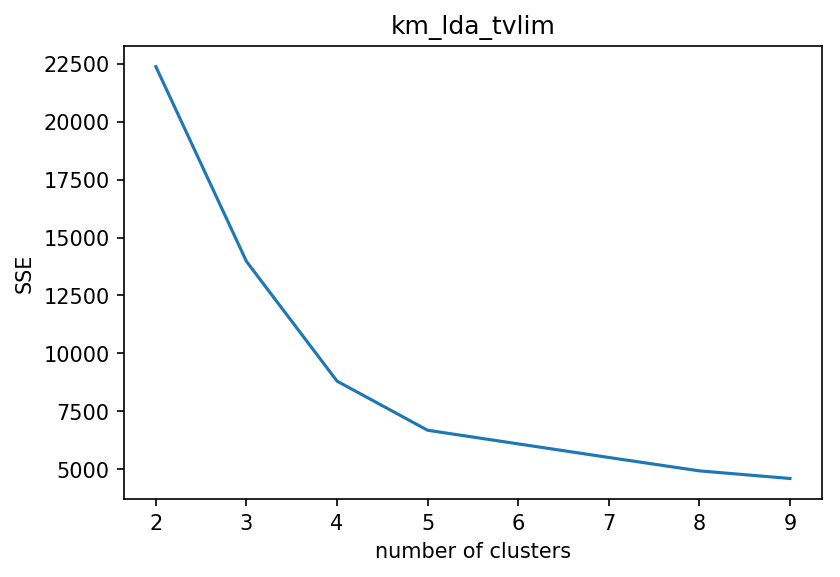

In [243]:
model = km_lda_tvlim
model_name = 'km_lda_tvlim'
k_list = list(np.arange(2,10))
plt.figure(dpi=150)
plot_score_clusters(model.vec_data,k_list)
plt.title(model_name)
plt.show;

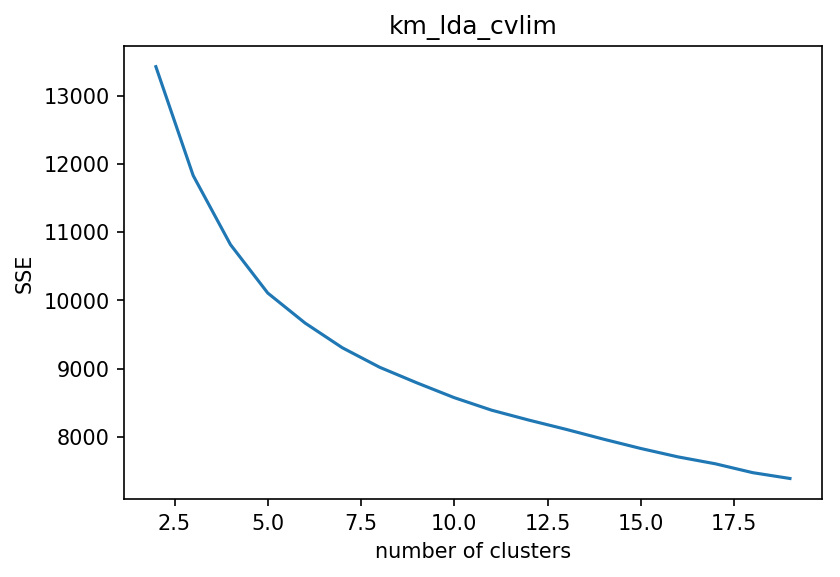

In [256]:
model = km_lda_cvlim
model_name = 'km_lda_cvlim'
k_list = list(np.arange(2,20))
plt.figure(dpi=150)
plot_score_clusters(model.vec_data,k_list)
plt.title(model_name)
plt.show;

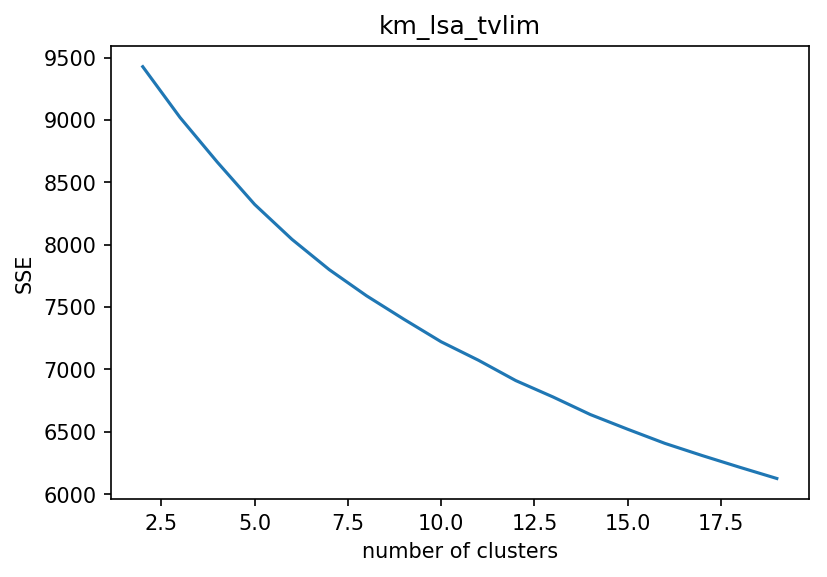

In [252]:
model = km_lsa_tvlim
model_name = 'km_lsa_tvlim'
k_list = list(np.arange(2,20))
plt.figure(dpi=150)
plot_score_clusters(model.vec_data,k_list)
plt.title(model_name)
plt.show;

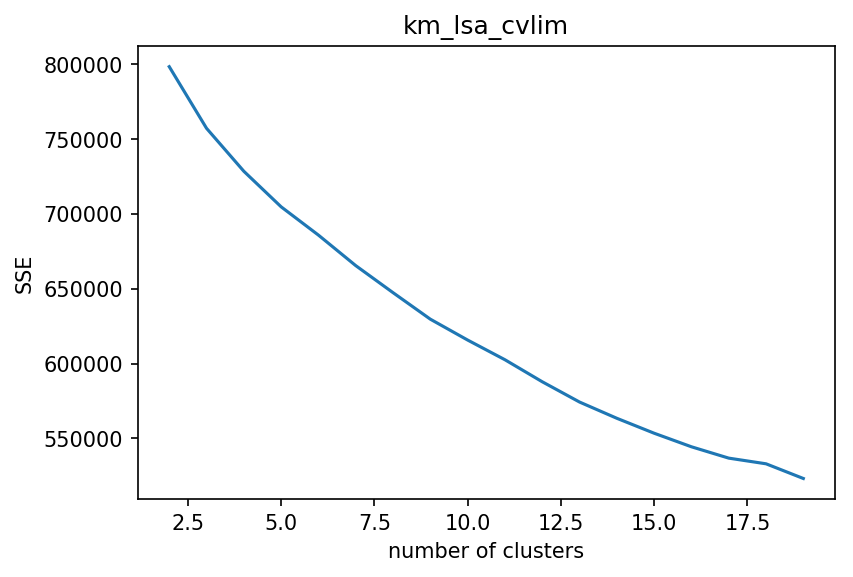

In [253]:
model = km_lsa_cvlim
model_name = 'km_lsa_cvlim'
k_list = list(np.arange(2,20))
plt.figure(dpi=150)
plot_score_clusters(model.vec_data,k_list)
plt.title(model_name)
plt.show;

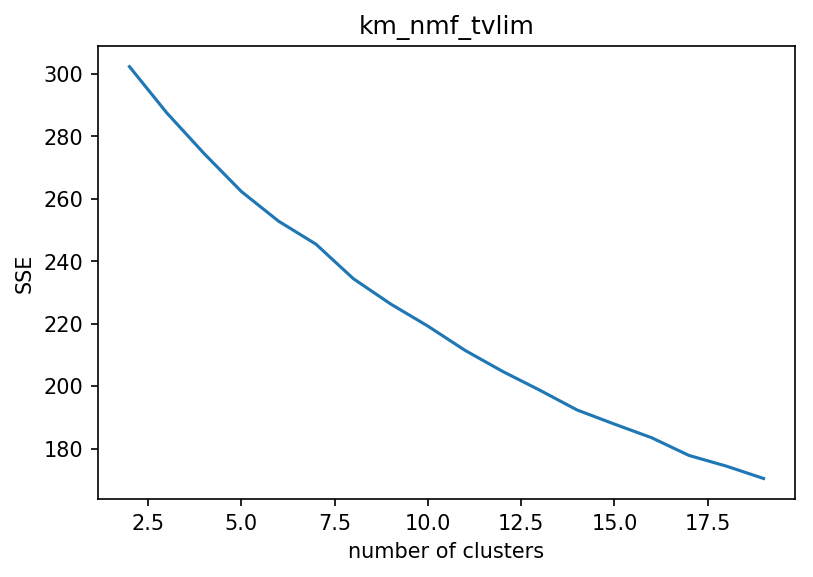

In [254]:
model = km_nmf_tvlim
model_name = 'km_nmf_tvlim'
k_list = list(np.arange(2,20))
plt.figure(dpi=150)
plot_score_clusters(model.vec_data,k_list)
plt.title(model_name)
plt.show;

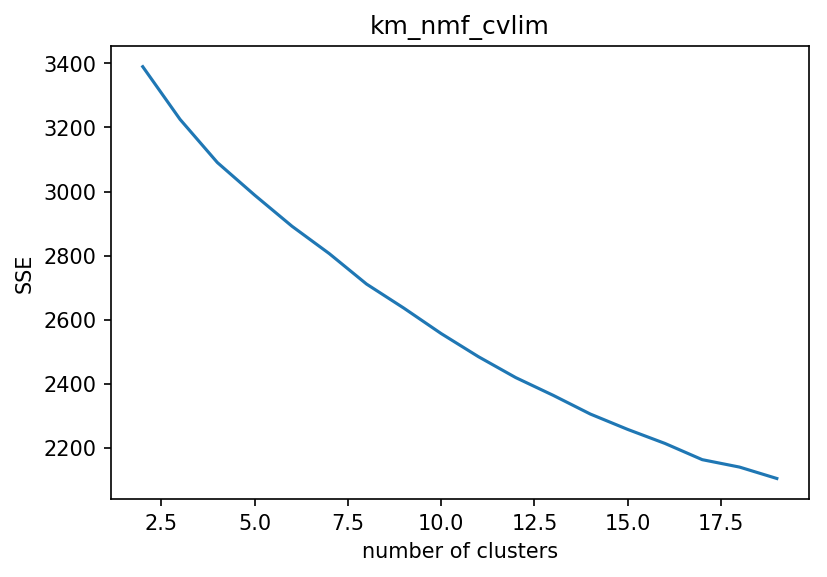

In [255]:
model = km_nmf_cvlim
model_name = 'km_nmf_cvlim'
k_list = list(np.arange(2,20))
plt.figure(dpi=150)
plot_score_clusters(model.vec_data,k_list)
plt.title(model_name)
plt.show;

In [293]:
tsne_5 = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
sample_texts_idx = np.random.randint(len(km_lda_tvlim.vec_data), size=10000)
sample_texts_features = km_lda_tvlim.vec_data[sample_texts_idx,:]

X_ne = tsne_5.fit_transform(sample_texts_features)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10000 samples in 0.248s...
[t-SNE] Computed neighbors for 10000 samples in 3.623s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.019844
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.389877
[t-SNE] Error after 300 iterations: 2.018461


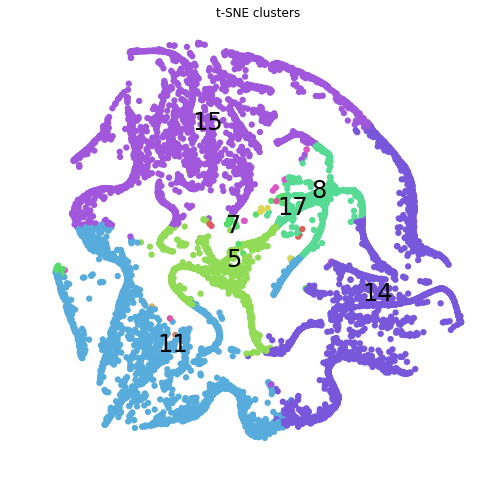

In [492]:
#topics = set(topic_id)
#n_topics = len(topics)
n_topics = 20
palette = np.array(sns.color_palette("hls", n_topics))
topic_id = [i.argmax() for i in sample_texts_features]

f = plt.figure(figsize=(8, 8))
ax = plt.subplot(aspect='equal')
sc = ax.scatter(X_ne[:,0], X_ne[:,1], lw=0, s=40,
                c=palette[topic_id])
#plt.xlim(-25, 25)
#plt.ylim(-25, 25)
ax.axis('off')
ax.axis('tight')
plt.title('t-SNE clusters');

# include labels for each topic.
txts = []
for i in topics:
    # Position of each label.
    xtext, ytext = np.round(np.median(X_ne[[x==i for x in topic_id]], axis=0))
    if X_ne[[x==i for x in topic_id]].shape[0] >= 10:
        txt = ax.text(xtext, ytext, str(i), fontsize=24)
    else:
        txt = ''
    txts.append(txt)

In [257]:
km_5 = KMeans(n_clusters=5, random_state=42, n_jobs=-1)
km_lda_tvlim.run_clusterer(km_5)

In [473]:
pickle.dump(km_5,open('pickles/km_5.pkl','wb'))
pickle.dump(km_lda_tvlim,open('pickles/km_lda_tvlim.pkl','wb'))

In [283]:
orig_texts = list(db.splitdata.find({}))
authors = [doc['author'] for doc in orig_texts]

In [490]:
# LDA topics contributing to each cluster by order of significance
[model.clusterer.cluster_centers_[cluster].argsort()[::-1][:5] for cluster in cluster_list]

# there is a lot of overlap... 

[array([15, 11, 14,  7,  5]),
 array([ 5, 14, 11, 15,  8]),
 array([11, 15, 14,  7,  5]),
 array([ 8, 14, 11,  5, 15]),
 array([14, 11, 15,  5,  8])]

In [491]:
#include in class def next time
model = km_lda_tvlim
cluster_list = range(0,model.clusterer.n_clusters)
#sort by proximity to center
for cluster in cluster_list:
    # top 5 topics from reducer that contributed to cluster
    topic_words = []
    for idx in model.clusterer.cluster_centers_[cluster].argsort()[::-1][:5]:
        topic_components = model.reducer.components_[idx]
        topic_words.extend([tvlim.get_feature_names()[i] for i in topic_components.argsort()[:-5-1:-1]])
    print('\nTopic',cluster)
    print(' '.join(topic_words))


Topic 0
quant magus tant nosc mult me uide ocul uolo aur alius pot praesto speci ostend dico fil hom faci pate reo spirit ute do dur

Topic 1
reo spirit ute do dur alius pot praesto speci ostend me uide ocul uolo aur quant magus tant nosc mult domin christ dico su noste

Topic 2
me uide ocul uolo aur quant magus tant nosc mult alius pot praesto speci ostend dico fil hom faci pate reo spirit ute do dur

Topic 3
domin christ dico su noste alius pot praesto speci ostend me uide ocul uolo aur reo spirit ute do dur quant magus tant nosc mult

Topic 4
alius pot praesto speci ostend me uide ocul uolo aur quant magus tant nosc mult reo spirit ute do dur domin christ dico su noste


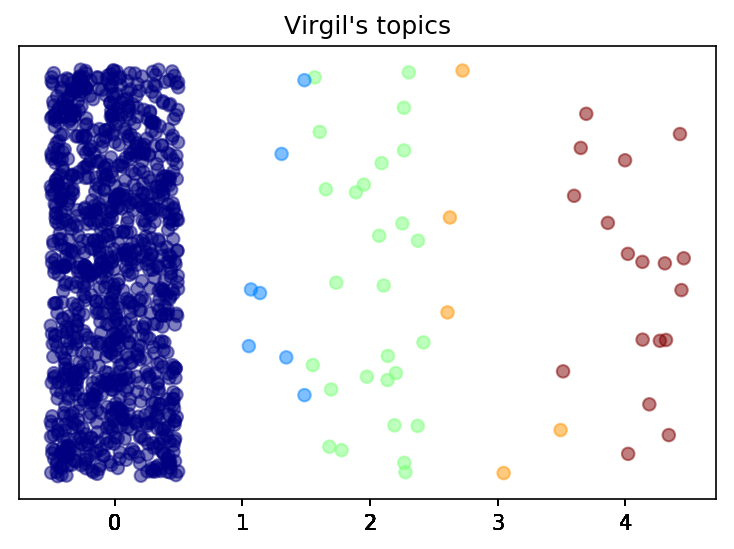

In [467]:
clusters_virgil = km_lda_tvlim.clusters[np.array(authors)=='Virgil']
plt.figure(dpi=150)
X_scatter = clusters_virgil+np.random.random(len(clusters_virgil)) 
y_scatter = np.random.random(len(clusters_virgil)) 
plt.scatter(X_scatter,y_scatter, c=clusters_virgil, cmap=plt.cm.jet, alpha=0.5)
plt.title('Virgil\'s topics')
plt.yticks([])
plt.xticks([i+0.5 for i in clusters_virgil],clusters_virgil);

# mostly in cluster 0 - cluster 0 is comprised of [15, 11, 14,  7,  5] for top 5 topics - topic 15 is philosopy which does not fit

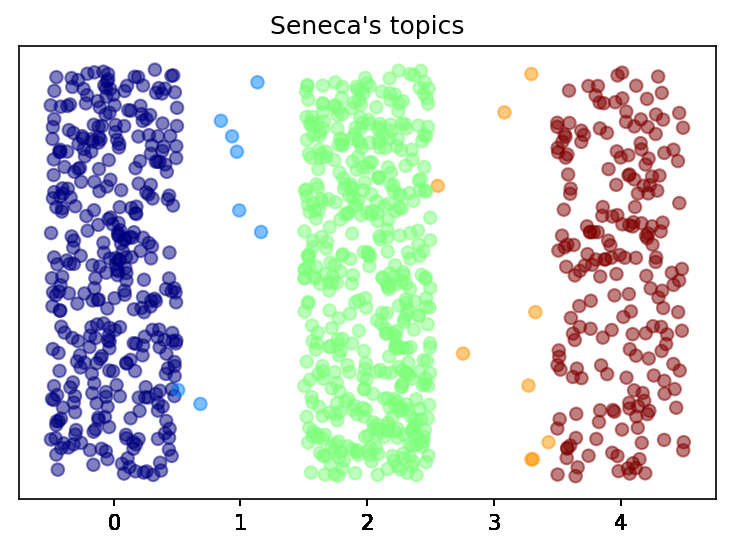

In [466]:
clusters_seneca = km_lda_tvlim.clusters[np.array(authors)=='Seneca Lucius Annaeus']

plt.figure(dpi=150)
X_scatter = clusters_seneca+np.random.random(len(clusters_seneca)) 
y_scatter = np.random.random(len(clusters_seneca)) 
plt.scatter(X_scatter,y_scatter, c=clusters_seneca, cmap=plt.cm.jet, alpha=0.5)
plt.title('Seneca\'s topics')
plt.yticks([])
plt.xticks([i+0.5 for i in clusters_seneca],clusters_seneca);

# clustered mostly in 0, 2, 4 - top 1 topic for those respective clusters are 15, 11, 14 - philosophy fits but the other two do not

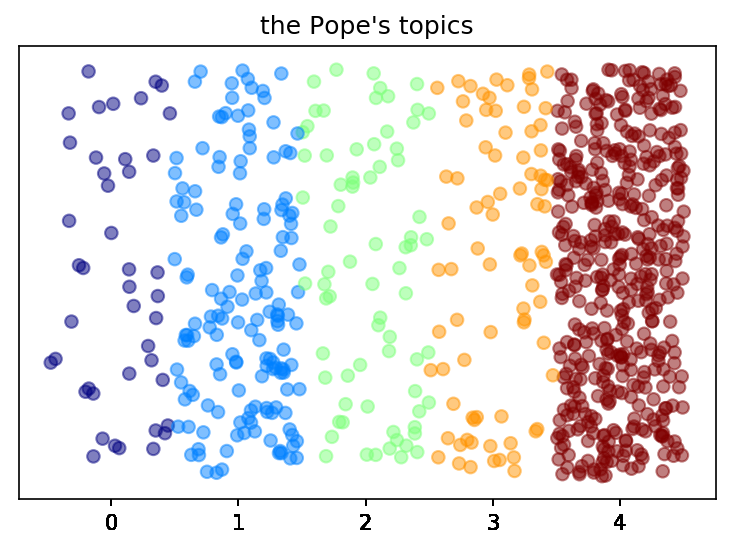

In [470]:
clusters_pope = km_lda_tvlim.clusters[np.array(authors)=='Catholic Church Pope']

plt.figure(dpi=150)
X_scatter = clusters_pope+np.random.random(len(clusters_pope)) 
y_scatter = np.random.random(len(clusters_pope)) 
plt.scatter(X_scatter,y_scatter, c=clusters_pope, cmap=plt.cm.jet, alpha=0.5)
plt.title('the Pope\'s topics')
plt.yticks([])
plt.xticks([i+0.5 for i in clusters_pope],clusters_pope);